In [9]:
#Import potrzebnych bilbiotek
import pynq
import os
import re
import time
import numpy as np
import sys
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
class wait_handles:
    """
    Create wait handles for multiple accelerators.
    """
    def __init__(self, handles_list):
        self.handles = handles_list

    def wait(self):
        for i in range(len(self.handles)):
            self.handles[i].wait()
            
class MyOverlay(pynq.Overlay):
    """
    Default init Overlay and run some functions for setup.
    """
    #delete bitstream argument and change download to True in future use!
    def __init__(self, xclbin, bitstream, download = False):
        self.bitstream = bitstream
        self.xclbin = xclbin
        #Delete for future use!
        self.reprogram()
        #Delete for future use!
        super().__init__(xclbin, download)
        self.__getAcceleratorTypes()
        self.__map_accels()
        self.__create_accel_work_group()
        # Other initialisation
        
    def reprogram(self):
        """
        On edge devices XRT couldn't reprogram FPGA. 
        But we can stil do that manually.
        """
        os.system(f"fpgautil -b {self.bitstream}")
    
    def __getAcceleratorTypes(self):
        """
        Return name and number of accelerators:
        If overlay have Vadd_1, Vadd_2, Vadd_3 in ip_dict()...
        It should return
        [[Vadd][3]]
        """
        klucze = self.ip_dict.keys()
        accelerators = list()
        accelerator_types = list()
        count = list()

        for accelerator in klucze:
            charind = accelerator.rfind('_')
            accelerators.append(accelerator[:charind:])

        accelerator_types = list(dict.fromkeys(accelerators))
        for accelerator in accelerator_types:    
            count.append(accelerators.count(accelerator))
            
        self.accel_container = [[accelerator_types, count]] 
        return [[accelerator_types, count]]
    
    def __get_accels(self, acc, cnt):
        """
        Utility function that maps all accelerator to workgroups.
        """
        func = getattr(self, f"{acc}_{cnt}")
        return func

    def __map_accels(self):
        """
        Returns a tuple of mapped accelerators, so we can acces them like
        accel_group[x], where x is index of accelerator.
        """
        self.accel_group = list()
        for i in range(len(self.accel_container)):
            temp = tuple(map(self.__get_accels, self.accel_container[i][0]*self.accel_container[i][1][0], range(1,self.accel_container[i][1][0]+1)))
            self.accel_group.append(temp)
        return self.accel_group
    
    def __create_accel_work_group(self):
        """
        Create new function based on accelerator groups found in overlay.
        For example found three Vadd accelerators:
        [[Vadd][3]] -> self.Vadd
        
        Where self is object that we create in main program.
        """
        for i in range(len(self.accel_container)):
            #Setattr powinien odpalać wszystkie akclelatory
            setattr(self, f"{self.accel_container[i][0][0]}_group", self.accel_group[i])
    
    def show_groups(self):
        """
        Helper function that shows detected accelerator groups, thier count and imput arguments.
        It is usefull for creating parallel run function.
        """
        print(f"Accelerator types: {len(self.accel_container)}")
        for i in range(len(self.accel_container)):
            print(f"Kernel: {self.accel_container[i][0][0]} Count: {self.accel_container[i][1][0]}\nArguments: {self.accel_group[i][0].signature}")
            #nb of arguments len(elo[0][0].signature.parameters.keys())
        
    def split_buffer(self, buffer, accelerator_group):
        """
        Utility function that splits input array into smaller arrays.
        Arr1 = [10, 10, 10, 10, 10]
        Arr2 = np.array_split(Arr1, 2)
        Arr2 will become [[10, 10][10, 10][10]]
        """
        acels = len(accelerator_group)
        minibuffer = np.array_split(buffer, acels)
        return minibuffer

    def get_elements_size(self, array_to_split):
        """
        Count elements of arrays in list.
        [[10, 10][10, 10][10]] -> [2, 2, 1]
        """
        size_split = list()
        for element in array_to_split:
            size_split.append(len(element))
        return size_split    

In [3]:
#Reprogram FPGA and xclbin
xclbinary = "/media/sd-mmcblk0p1/Vadd4/vadd.xclbin"
xcl_bitstream = "/lib/firmware/base/vpl_gen_fixed.bit.bin"
t0 = time.time()
ol = MyOverlay(xclbinary, xcl_bitstream)
t1 = time.time()

In [4]:
#ol.show_groups()
"""
Parallel run function. This need to be created manually, because we can't detect dependancies,
for example between arg[0][x] and arg[1][x] where arg[1][x] is size of arg[0][x]. 
"""
def par_run(*args, accelerator_group=()):
        acels = len(accelerator_group)
        handle = list()

        for i in range(acels):
            #Basicly a template where you need to change args[0][i], args[1][i], args[2] only!
            h = accelerator_group[i].start(args[0][i], args[1][i], args[2])
            handle.append(h)

        return wait_handles(handle)
    


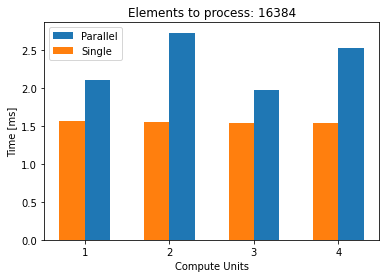

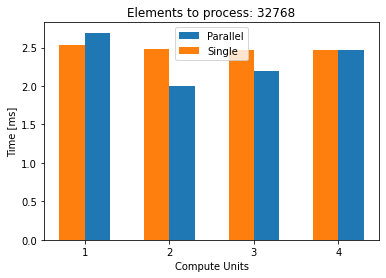

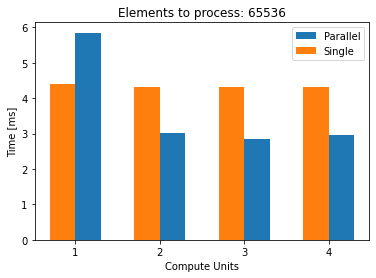

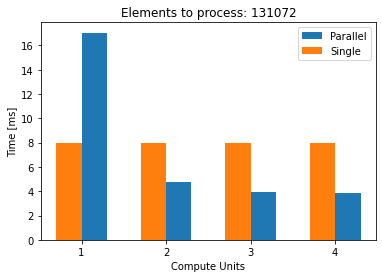

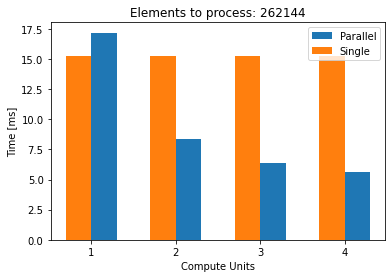

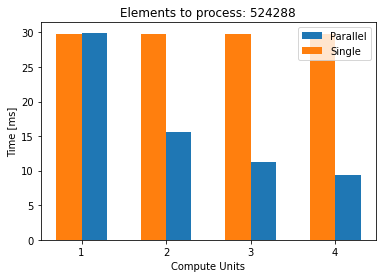

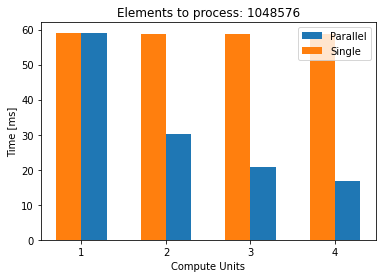

In [125]:
def calc_run_time_par(cnt, size, increment_value):
    workgroup = ol.vadd_group[0:cnt]  
    a = pynq.allocate(size)   
    
    a_split = ol.split_buffer(a, workgroup)
    a_elements_size = ol.get_elements_size(a_split)
    #print(f"A: {a}")
    t0 = time.time()
    h = par_run(a_split, a_elements_size, increment_value, accelerator_group=workgroup)
    h.wait()
    t1 = time.time()
    #print(f"A: {a}")
    
    execution_time = t1-t0
    return execution_time

def calc_run_time(size, increment_value):
    workgroup = ol.vadd_group[0:1]
    
    a = pynq.allocate(size)
    #print(f"A: {a}")
    t0 = time.time()
    handle = workgroup[0].start(a, size, increment_value)
    handle.wait()
    t1 = time.time()
    #print(f"A: {a}")
    
    exec_time = t1-t0
    return exec_time


inc_val = 10
parallel_elapsed_times = list()
single_elapsed_times = list()
power_indexes = list()
cmp_unit_indexes = list()

for i in range(14, 21):
    power = 2**i
    parallel_elapsed_times = list()
    single_elapsed_times = list()
    power_indexes = list()
    cmp_unit_indexes = list()
    for cmp_unit in range(1, 5):
        parallel_elapsed_times.append(calc_run_time_par(cmp_unit, power, inc_val))
        single_elapsed_times.append(calc_run_time(power, inc_val))
        power_indexes.append(power)
        cmp_unit_indexes.append(cmp_unit)


    
    x_axis_data = cmp_unit_indexes
    
    parallel_elapsed_axis_data = np.multiply(parallel_elapsed_times,1000.0)
    single_elapsed_axis_data = np.multiply(single_elapsed_times,1000.0)

    width = 0.3
    move = np.ones(len(x_axis_data))*width
    
    fig, ax = plt.subplots()
    
    ax.bar(x_axis_data+move, parallel_elapsed_axis_data, width, label='Parallel')
    ax.bar(x_axis_data, single_elapsed_axis_data, width, label='Single')

    plt.xticks(x_axis_data+(move)*0.5 , range(1, 5))
    ax.set_ylabel('Time [ms]')
    ax.set_xlabel('Compute Units')
    ax.set_title(f'Elements to process: {power}')
    ax.legend()
    
    plt.savefig(f'/home/root/{power}.png')
    plt.show()
    


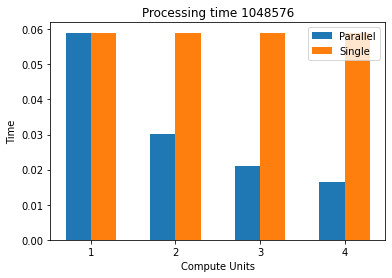

In [93]:
x_axis_data = cmp_unit_indexes

parallel_elapsed_axis_data = parallel_elapsed_times
single_elapsed_axis_data = single_elapsed_times

width = 0.3
move = np.ones(len(x_axis_data))*width
               
fig, ax = plt.subplots()
#bar(x, height, width=0.8, bottom=None, *, align='center',
#data=None, **kwargs)[source]
ax.bar(x_axis_data, parallel_elapsed_axis_data, width, label='Parallel')
ax.bar(x_axis_data+move, single_elapsed_axis_data, width, label='Single')

plt.xticks(x_axis_data+(move)*0.5 , range(1, 5))
ax.set_ylabel('Time')
ax.set_xlabel('Compute Units')
ax.set_title(f'Processing time {power}')
ax.legend()

plt.show()

In [88]:
#Pass
size = 2**20
kkk = list()
for elo in range(5): 
    kkk.append(pynq.allocate(size))


PynqBuffer([0, 0, 0, ..., 0, 0, 0], dtype=uint32)

PynqBuffer([0, 0, 0, ..., 0, 0, 0], dtype=uint32)

PynqBuffer([0, 0, 0, ..., 0, 0, 0], dtype=uint32)